In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pystan
import seaborn as sns

In [2]:
def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

0.1


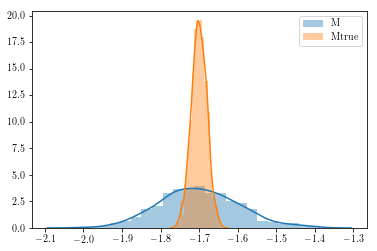

In [75]:
npts = 1000
sigma = 0.02
mean = -1.7
M_true = np.random.randn(npts) * sigma + mean
unc = 0.1
M = M_true + np.random.randn(npts) * unc
sns.distplot(M, label='M')
sns.distplot(M_true, label='Mtrue')
plt.legend()

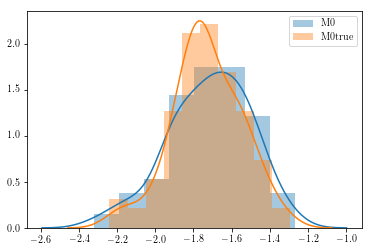

In [76]:
npts = 100
sigma0 = 0.2
mean0=-1.7
M_true0 = np.random.randn(npts) * sigma0 + mean0
M0 = M_true0 + np.random.randn(npts) * unc
sns.distplot(M0, label='M0')
sns.distplot(M_true0, label='M0true')
plt.legend()

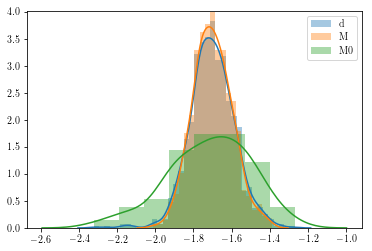

In [77]:
sns.distplot(np.append(M, M0),label='d')
sns.distplot(M, label='M')
sns.distplot(M0,label='M0')
plt.legend()
plt.show()

In [108]:
local = True
if local:
    clump_model = '''
    data {
        int<lower=0> N;
        real M[N];
        real<lower = 0> M_err[N];
    }
    parameters {
        real mu;
        real muo;
        real<lower =0.001> sigma;
        real<lower = 0> sigo;
        real<lower = 0, upper = 1> Q;
        real M_true[N];
    }
    model {   
        M ~ normal(M_true, M_err); // Measurement uncertainty
        mu ~ normal(-1.7,.1);
        sigma ~ normal(0.02,0.01);
        muo ~ normal(-1.7, .1);
        sigo ~ normal(0.2, 0.1);
        Q ~ normal(.9,.1);
        for (n in 1:N){
            target += log_mix(Q,
                        normal_lpdf(M_true[n]|mu, sigma),
                        normal_lpdf(M_true[n]|muo, sigo));
        }
    }

    '''
    sm = pystan.StanModel(model_code=clump_model, model_name='ClumpModel')
else:
    import pickle
    print('Loading in existing Stan Model') 
    sm = pickle.load(open('asterostan.pkl', 'rb'))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL ClumpModel_c625b3e3da093aad3eefd1ebf582c9fe NOW.


In [116]:
d = np.append(M, M0)
print(len(M))
print(len(d))
pQ = float(len(M))/float(len(d))
print(pQ)

1000
1100
0.909090909091


In [110]:
dat = {'N': len(d),
      'M': d,
      'M_err': np.ones(len(d))*unc}
start = [{'mu':mean,
         'sigma':sigma,
         'muo':mean0,
         'sigo':sigma0,
         'Q':pQ}]
fit = sm.sampling(data=dat, iter=2000, chains=1)


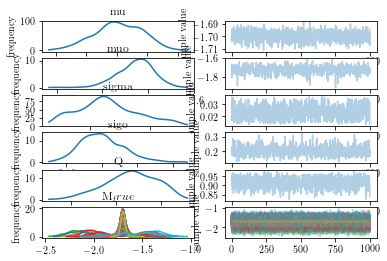

In [111]:
fit.plot()
plt.show()

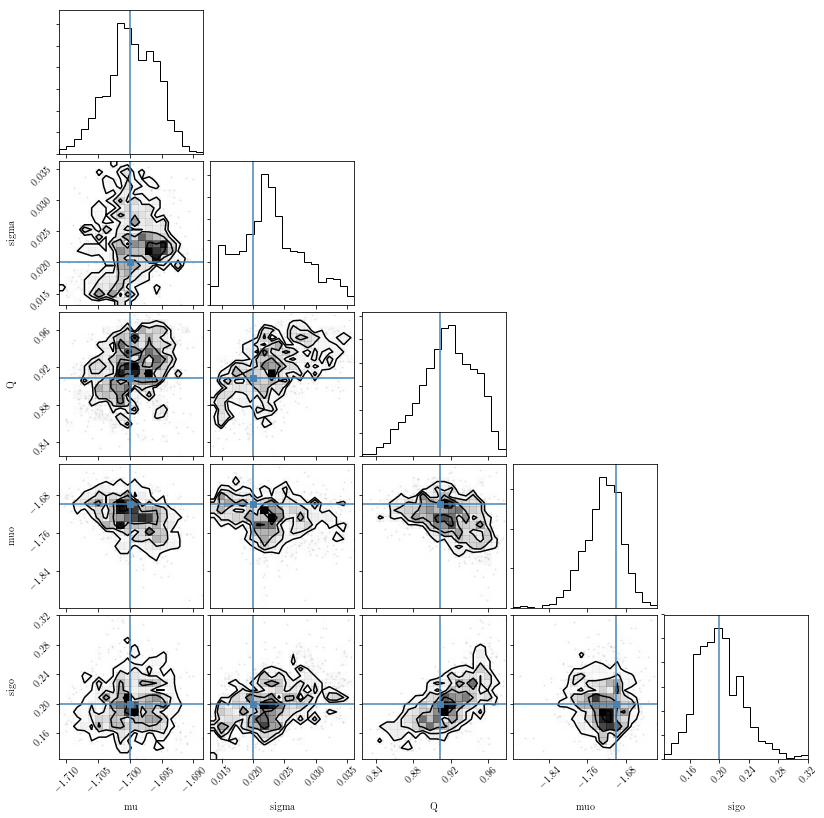

In [119]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['muo'],fit['sigo']]).T
truths=[-1.7,0.02,pQ,-1.7,0.2]
corner.corner(chain,labels=['mu','sigma','Q','muo','sigo'],truths=truths)
plt.show()

In [120]:
rmu = np.median(fit['mu'])
rsigma = np.median(fit['sigma'])
rsigo = (np.median(fit['sigo']))
rmuo = (np.median(fit['muo']))
rQ = np.median(fit['Q'])

fg = normal(d, rmu, rsigma)
bg = normal(d, rmuo, rsigo)
L = rQ*fg + (1-rQ)*bg

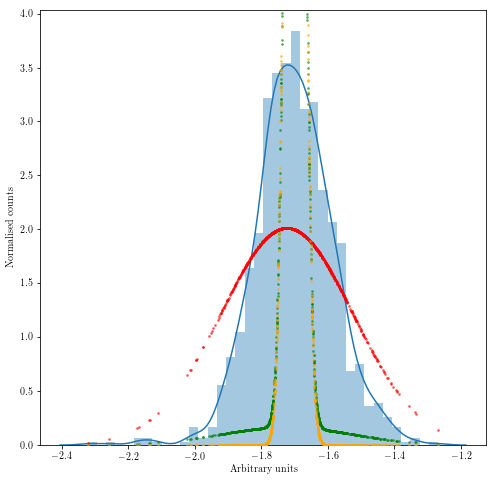

In [121]:
fig, ax = plt.subplots(1,figsize=(8,8))
sns.distplot(d,ax=ax)
ax.scatter(d,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
ax.scatter(d,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
ax.scatter(d, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

ax.set_xlabel('Arbitrary units')
ax.set_ylabel('Normalised counts')
plt.show()

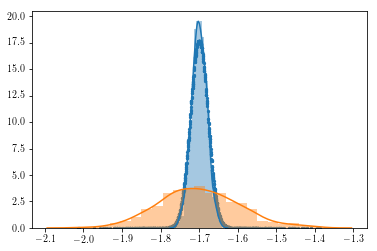

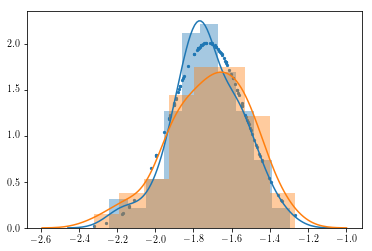

In [123]:
Mfg = normal(M, rmu, rsigma)
Mbg = normal(M0, rmuo, rsigo)
sns.distplot(M_true)
sns.distplot(M)
plt.scatter(M,Mfg,s=5)
plt.show()
sns.distplot(M_true0)
sns.distplot(M0)
plt.scatter(M0,Mbg,s=5)
plt.show()

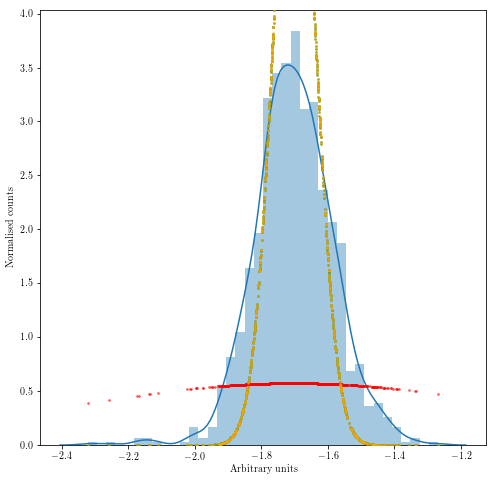

In [105]:
'''Transformed into mu, sig space'''
fig, ax = plt.subplots(1,figsize=(8,8))
sns.distplot(d,ax=ax)
ax.scatter(d,fg,s=3,label='Foreground', alpha=.5,c='orange',zorder=999)
ax.scatter(d,bg,s=3,label='Background', alpha=.5,c='red',zorder=998)
ax.scatter(d, L,s=3,label='True likelihood', alpha=.5,c='green',zorder=997)

ax.set_xlabel('Arbitrary units')
ax.set_ylabel('Normalised counts')
plt.show()

In [18]:
print(fit)

Inference for Stan model: ClumpModel_21fa0c49f19426adf399cc72a189aabf.
1 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=2000.

                   mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                  1.7  1.0e-4 3.4e-3   1.69    1.7    1.7    1.7   1.71   1146    1.0
sigma              0.02  2.5e-4 2.2e-3   0.01   0.01   0.02   0.02   0.02     81    1.0
M_true_std[0]      -0.2    0.07   1.93  -4.48  -0.81  -0.04   0.65   2.21    831    1.0
M_true_std[1]      0.55    0.09   2.16  -1.71  -0.38   0.27   0.97   6.59    583    1.0
M_true_std[2]      0.42    0.08    2.1  -2.02  -0.52   0.21   0.92    6.3    633   1.01
M_true_std[3]      0.52     0.1   2.05  -1.68  -0.52   0.25   0.97   6.08    451    1.0
M_true_std[4]      0.57    0.12    2.4  -1.96  -0.48   0.22   1.03   7.49    388    1.0
M_true_std[5]     -1.33    0.22   3.43 -12.61  -1.36  -0.48   0.26   1.87    246    1.0
M_true_std[6]     -